<h1><b>[XI - CatBoost]</b></h1>

The result will be save in `data/CATBOOST.csv` and the probabilities in `data/PROBS_CATBOOST.npy`

Note that the original `data/PROBS_CATBOOST.npy` is already available.

___________________________

# Initialisation

In [1]:
import catboost as cat
from catboost import CatBoostClassifier, Pool
print('CatBoost version',cat.__version__)

CatBoost version 1.2.2


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)  
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split

In [3]:
train_df = pd.read_csv("/kaggle/input/ml-cs-df-8/train_df_FINAL.csv")
test_df = pd.read_csv("/kaggle/input/ml-cs-df-8/test_df_FINAL.csv")

In [4]:
train_df = train_df[(train_df.index < 195453) | (train_df.index > 197302)]

In [5]:
change_types = train_df["change_type"].unique()
for change_type in change_types:
    for column in train_df.columns:
        if column == "geometry":
            continue
        train_df.loc[(train_df["change_type"]==change_type) & (train_df[column].isnull()), column] = train_df.loc[(train_df["change_type"]==change_type), column].mode()[0]

In [6]:
feature_names=[ 'urban_type_N,A', 'urban_type_UrbanSlum', 'urban_type_Rural', 'urban_type_DenseUrban', 'urban_type_Industrial', 'urban_type_SparseUrban', 
                #'urban_type_Dense Urban,Industrial', 'urban_type_Dense Urban,Urban Slum', 'urban_type_Sparse Urban,Industrial', 'urban_type_Sparse Urban,Urban Slum', 
               
                'geography_type_N,A', 'geography_type_Desert', 'geography_type_Farms', 'geography_type_DenseForest', 'geography_type_Hills', 'geography_type_River', 'geography_type_GrassLand', 'geography_type_Snow', 'geography_type_Lakes', 'geography_type_BarrenLand', 'geography_type_Coastal', 'geography_type_SparseForest', 
                #'geography_type_Sparse Forest,Grass Land', 'geography_type_Sparse Forest,Farms', 'geography_type_Sparse Forest,Dense Forest,Grass Land', 'geography_type_Barren Land,Sparse Forest', 'geography_type_Sparse Forest,Dense Forest', 'geography_type_Sparse Forest,Grass Land,Lakes', 'geography_type_Sparse Forest,Farms,Lakes', 'geography_type_River,Sparse Forest,Grass Land', 'geography_type_River,Sparse Forest', 'geography_type_Sparse Forest,Dense Forest,Grass Land,Lakes', 'geography_type_Barren Land,Sparse Forest,Grass Land', 'geography_type_Dense Forest,Grass Land', 'geography_type_River,Sparse Forest,Farms', 
               
                #'geourban_geography_type_Desert_urban_type_Industrial', 'geourban_geography_type_Farms_urban_type_Rural', 'geourban_geography_type_Farms_urban_type_DenseUrban', 'geourban_geography_type_Farms_urban_type_Industrial', 'geourban_geography_type_Farms_urban_type_SparseUrban', 'geourban_geography_type_DenseForest_urban_type_UrbanSlum', 'geourban_geography_type_DenseForest_urban_type_Rural', 'geourban_geography_type_DenseForest_urban_type_DenseUrban', 'geourban_geography_type_DenseForest_urban_type_Industrial', 'geourban_geography_type_DenseForest_urban_type_SparseUrban', 'geourban_geography_type_River_urban_type_Rural', 'geourban_geography_type_River_urban_type_DenseUrban', 'geourban_geography_type_River_urban_type_Industrial', 'geourban_geography_type_River_urban_type_SparseUrban', 'geourban_geography_type_GrassLand_urban_type_Rural', 'geourban_geography_type_GrassLand_urban_type_DenseUrban', 'geourban_geography_type_GrassLand_urban_type_Industrial', 'geourban_geography_type_GrassLand_urban_type_SparseUrban', 'geourban_geography_type_Lakes_urban_type_Rural', 'geourban_geography_type_Lakes_urban_type_DenseUrban', 'geourban_geography_type_Lakes_urban_type_Industrial', 'geourban_geography_type_Lakes_urban_type_SparseUrban', 'geourban_geography_type_BarrenLand_urban_type_Rural', 'geourban_geography_type_BarrenLand_urban_type_DenseUrban', 'geourban_geography_type_BarrenLand_urban_type_Industrial', 'geourban_geography_type_BarrenLand_urban_type_SparseUrban', 'geourban_geography_type_Coastal_urban_type_SparseUrban', 'geourban_geography_type_SparseForest_urban_type_UrbanSlum', 'geourban_geography_type_SparseForest_urban_type_Rural', 'geourban_geography_type_SparseForest_urban_type_DenseUrban', 'geourban_geography_type_SparseForest_urban_type_Industrial', 'geourban_geography_type_SparseForest_urban_type_SparseUrban', 
               
                'img_red_mean_date0', 'img_red_mean_date1', 'img_red_mean_date2', 'img_red_mean_date3', 'img_red_mean_date4', 
                'img_green_mean_date0', 'img_green_mean_date1', 'img_green_mean_date2', 'img_green_mean_date3', 'img_green_mean_date4', 
                'img_blue_mean_date0', 'img_blue_mean_date1', 'img_blue_mean_date2', 'img_blue_mean_date3', 'img_blue_mean_date4', 
               
                'img_red_std_date0', 'img_red_std_date1', 'img_red_std_date2', 'img_red_std_date3', 'img_red_std_date4', 
                'img_green_std_date0', 'img_green_std_date1', 'img_green_std_date2', 'img_green_std_date3', 'img_green_std_date4', 
                'img_blue_std_date0', 'img_blue_std_date1', 'img_blue_std_date2', 'img_blue_std_date3', 'img_blue_std_date4', 
               
                'change_status_date0_Construction Done', 'change_status_date0_Construction Midway', 'change_status_date0_Construction Started', 'change_status_date0_Excavation', 'change_status_date0_Greenland', 'change_status_date0_Land Cleared', 'change_status_date0_Materials Dumped', 'change_status_date0_Materials Introduced', 'change_status_date0_Operational', 'change_status_date0_Prior Construction', 
                'change_status_date1_Construction Done', 'change_status_date1_Construction Midway', 'change_status_date1_Construction Started', 'change_status_date1_Excavation', 'change_status_date1_Greenland', 'change_status_date1_Land Cleared', 'change_status_date1_Materials Dumped', 'change_status_date1_Materials Introduced', 'change_status_date1_Operational', 'change_status_date1_Prior Construction', 
                'change_status_date2_Construction Done', 'change_status_date2_Construction Midway', 'change_status_date2_Construction Started', 'change_status_date2_Excavation', 'change_status_date2_Greenland', 'change_status_date2_Land Cleared', 'change_status_date2_Materials Dumped', 'change_status_date2_Materials Introduced', 'change_status_date2_Operational', 'change_status_date2_Prior Construction', 
                'change_status_date3_Construction Done', 'change_status_date3_Construction Midway', 'change_status_date3_Construction Started', 'change_status_date3_Excavation', 'change_status_date3_Greenland', 'change_status_date3_Land Cleared', 'change_status_date3_Materials Dumped', 'change_status_date3_Materials Introduced', 'change_status_date3_Operational', 'change_status_date3_Prior Construction', 
                'change_status_date4_Construction Done', 'change_status_date4_Construction Midway', 'change_status_date4_Construction Started', 'change_status_date4_Excavation', 'change_status_date4_Greenland', 'change_status_date4_Land Cleared', 'change_status_date4_Materials Dumped', 'change_status_date4_Materials Introduced', 'change_status_date4_Operational', 'change_status_date4_Prior Construction', 
               
                'change_status_Prior Construction', 'change_status_Greenland', 'change_status_Land Cleared', 'change_status_Excavation', 'change_status_Materials Dumped', 'change_status_Materials Introduced', 'change_status_Construction Started', 'change_status_Construction Midway', 'change_status_Construction Done', 'change_status_Operational', 
                'change_status_date0_encoded', 'change_status_date1_encoded', 'change_status_date2_encoded', 'change_status_date3_encoded', 'change_status_date4_encoded', 
                'change_status_date_4-0', 'change_status_date_1-0', 'change_status_date_2-1', 'change_status_date_3-2', 'change_status_date_4-3', 
               
                'img_mean_date0', 'img_std_date0', 'img_mean_date1', 'img_std_date1', 'img_mean_date2', 'img_std_date2', 'img_mean_date3', 'img_std_date3', 'img_mean_date4', 'img_std_date4', 
                'img_mean_date_4-0', 'img_mean_date_1-0', 'img_mean_date_2-1', 'img_mean_date_3-2', 'img_mean_date_4-3', 'img_std_date_4-0', 'img_std_date_1-0', 'img_std_date_2-1', 'img_std_date_3-2', 'img_std_date_4-3', 
               
                'img_red_mean_date_4-0', 'img_red_mean_date_1-0', 'img_red_mean_date_2-1', 'img_red_mean_date_3-2', 'img_red_mean_date_4-3', 'img_green_mean_date_4-0', 'img_green_mean_date_1-0', 'img_green_mean_date_2-1', 'img_green_mean_date_3-2', 'img_green_mean_date_4-3', 'img_blue_mean_date_4-0', 'img_blue_mean_date_1-0', 'img_blue_mean_date_2-1', 'img_blue_mean_date_3-2', 'img_blue_mean_date_4-3', 'img_red_std_date_4-0', 'img_red_std_date_1-0', 'img_red_std_date_2-1', 'img_red_std_date_3-2', 'img_red_std_date_4-3', 'img_green_std_date_4-0', 'img_green_std_date_1-0', 'img_green_std_date_2-1', 'img_green_std_date_3-2', 'img_green_std_date_4-3', 'img_blue_std_date_4-0', 'img_blue_std_date_1-0', 'img_blue_std_date_2-1', 'img_blue_std_date_3-2', 'img_blue_std_date_4-3', 
                
                'date_1-0', 'date_2-1', 'date_3-2', 'date_4-3', 'date_4-0', 'date_0-0min', 
                'img_mean_date_4-0/Date', 'img_mean_date_1-0/Date', 'img_mean_date_2-1/Date', 'img_mean_date_3-2/Date', 'img_mean_date_4-3/Date', 'img_std_date_4-0/Date', 'img_std_date_1-0/Date', 'img_std_date_2-1/Date', 'img_std_date_3-2/Date', 'img_std_date_4-3/Date', 'img_red_mean_date_4-0/Date', 'img_red_mean_date_1-0/Date', 'img_red_mean_date_2-1/Date', 'img_red_mean_date_3-2/Date', 'img_red_mean_date_4-3/Date', 'img_green_mean_date_4-0/Date', 'img_green_mean_date_1-0/Date', 'img_green_mean_date_2-1/Date', 'img_green_mean_date_3-2/Date', 'img_green_mean_date_4-3/Date', 'img_blue_mean_date_4-0/Date', 'img_blue_mean_date_1-0/Date', 'img_blue_mean_date_2-1/Date', 'img_blue_mean_date_3-2/Date', 'img_blue_mean_date_4-3/Date', 'img_red_std_date_4-0/Date', 'img_red_std_date_1-0/Date', 'img_red_std_date_2-1/Date', 'img_red_std_date_3-2/Date', 'img_red_std_date_4-3/Date', 'img_green_std_date_4-0/Date', 'img_green_std_date_1-0/Date', 'img_green_std_date_2-1/Date', 'img_green_std_date_3-2/Date', 'img_green_std_date_4-3/Date', 'img_blue_std_date_4-0/Date', 'img_blue_std_date_1-0/Date', 'img_blue_std_date_2-1/Date', 'img_blue_std_date_3-2/Date', 'img_blue_std_date_4-3/Date', 
                'change_status_date_4-0/Date', 'change_status_date_1-0/Date', 'change_status_date_2-1/Date', 'change_status_date_3-2/Date', 'change_status_date_4-3/Date', 
               
                'geometry_area', 'geometry_perimeter', 'geometry_inscribed_circle_radius', 'geometry_compactness', 'geometry_convexity', 'geometry_vertices', 'geometry_bboxwidth', 'geometry_bboxheight', 'geometry_bboxratio', 'geometry_bboxarea', 'geometry_bboxperimeter', 
                #'geometry_aspectratio', 
                'geometry_diameter', 'geometry_minumum_bounding_circle', 'geometry_minimum_rotated_rectangle', 
               
                'neighb_density', 'neighb_nb', 'neighb_similar', 
                'neighb_maxdiff_change_status_date0_0.001', 'neighb_maxdiff_change_status_date1_0.001', 'neighb_maxdiff_change_status_date2_0.001', 'neighb_maxdiff_change_status_date3_0.001', 'neighb_maxdiff_change_status_date4_0.001', 
                'neighb_maxdiff_change_status_date0_0.003', 'neighb_maxdiff_change_status_date1_0.003', 'neighb_maxdiff_change_status_date2_0.003', 'neighb_maxdiff_change_status_date3_0.003', 'neighb_maxdiff_change_status_date4_0.003', 
                'neighb_maxdiff_meancolor_0', 'neighb_maxdiff_meancolor_1', 'neighb_maxdiff_meancolor_2', 'neighb_maxdiff_meancolor_3', 'neighb_maxdiff_meancolor_4', 
                'neighb_maxdiff_stdcolor_0', 'neighb_maxdiff_stdcolor_1', 'neighb_maxdiff_stdcolor_2', 'neighb_maxdiff_stdcolor_3', 'neighb_maxdiff_stdcolor_4', 
               
                'neighb_meandiff_changestatus_0', 'neighb_meandiff_changestatus_1', 'neighb_meandiff_changestatus_2', 'neighb_meandiff_changestatus_3', 'neighb_meandiff_changestatus_4', 
                'neighb_meandiff_meancolor_0', 'neighb_meandiff_meancolor_1', 'neighb_meandiff_meancolor_2', 'neighb_meandiff_meancolor_3', 'neighb_meandiff_meancolor_4', 
                'neighb_meandiff_stdcolor_0', 'neighb_meandiff_stdcolor_1', 'neighb_meandiff_stdcolor_2', 'neighb_meandiff_stdcolor_3', 'neighb_meandiff_stdcolor_4'
            ]

In [7]:
X = train_df[feature_names].to_numpy()
Y = train_df['change_type'].to_numpy()
X_test = test_df[feature_names].to_numpy()

In [8]:
from sklearn.impute import SimpleImputer

# Handle NaN values using SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(np.concatenate([X, X_test], axis=0))
X_test = imp_mean.transform(X_test)

In [9]:
print(X.shape, Y.shape, X_test.shape)

(294296, 271) (294296,) (120526, 271)


# Train test split

In [10]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=65, stratify=Y)

In [11]:
np.unique(Y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([ 25141,  11424, 117708,  79988,   1058,    117]))

In [12]:
"""
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy={})
X_under, Y_under = rus.fit_resample(X_train, Y_train)
np.unique(Y_under, return_counts=True)

## TEST FINALL
#X_under, Y_under = X, Y


categorical_columns = []
for iColumn in range(len(X_train[0])):
    if len(np.unique(X_train[:,iColumn])) < 300:
        #print(feature_names[iColumn], len(np.unique(X_train[:,iColumn])))
        categorical_columns.append(iColumn)
#categorical_columns

from imblearn.over_sampling import SMOTE, SMOTENC

#sm = SMOTE(random_state=42, sampling_strategy={5:30000})
sm = SMOTENC(random_state=42, sampling_strategy={}, categorical_features=categorical_columns)
X_over, Y_over = sm.fit_resample(X_under, Y_under)
#X_over, Y_over = sm.fit_resample(X, Y)

#X_over, Y_over = X_under, Y_under

#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=0, sampling_strategy={5:50000})

#X_over, Y_over = ros.fit_resample(X_under, Y_under)

#pd.DataFrame(X_under[Y_under == 5][119:]).head(n=5)
#pd.DataFrame(X_over[Y_over == 5][119:]).head(n=5)
np.unique(Y_over, return_counts=True)
"""


'\nfrom imblearn.under_sampling import RandomUnderSampler\n\nrus = RandomUnderSampler(random_state=42, sampling_strategy={})\nX_under, Y_under = rus.fit_resample(X_train, Y_train)\nnp.unique(Y_under, return_counts=True)\n\n## TEST FINALL\n#X_under, Y_under = X, Y\n\n\ncategorical_columns = []\nfor iColumn in range(len(X_train[0])):\n    if len(np.unique(X_train[:,iColumn])) < 300:\n        #print(feature_names[iColumn], len(np.unique(X_train[:,iColumn])))\n        categorical_columns.append(iColumn)\n#categorical_columns\n\nfrom imblearn.over_sampling import SMOTE, SMOTENC\n\n#sm = SMOTE(random_state=42, sampling_strategy={5:30000})\nsm = SMOTENC(random_state=42, sampling_strategy={}, categorical_features=categorical_columns)\nX_over, Y_over = sm.fit_resample(X_under, Y_under)\n#X_over, Y_over = sm.fit_resample(X, Y)\n\n#X_over, Y_over = X_under, Y_under\n\n#from imblearn.over_sampling import RandomOverSampler\n#ros = RandomOverSampler(random_state=0, sampling_strategy={5:50000})\n\n#X

In [13]:
def printScores(y_true, y_predict):
    f1_score_micro = f1_score(y_true, y_predict, average='micro')
    f1_score_macro = f1_score(y_true, y_predict, average='macro')
    f1_score_weighted = f1_score(y_true, y_predict, average='weighted')
    train_conf_matrix = confusion_matrix(y_true, y_predict)
    print("F1 score micro", f1_score_micro)
    print("F1 score macro", f1_score_macro)
    print("F1 score weighted", f1_score_weighted)
    print(train_conf_matrix)

# Optuna

In [14]:
import optuna

In [15]:

train_pool = Pool(
    data = X_train,
    label = Y_train,
)

valid_pool = Pool(
    data = X_valid,
    label = Y_valid,
)

In [16]:
"""
def objective(trial):
    
    param = {
        'loss_function': 'MultiClass',
        'classes_count':6,
        'task_type': 'GPU',
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        #'rsm': trial.suggest_uniform('rsm', 0.3, 1.0),
        #'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.05),
        'n_estimators':  1500,
        'max_depth': trial.suggest_categorical('max_depth', [5,6,7,8,9,10,11,12,13,14,15]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }
    model = CatBoostClassifier(**param)  
    
    #model.fit(X_train,Y_train,eval_set=[(X_valid,Y_valid)],early_stopping_rounds=20,verbose=False)
    
    model.fit(train_pool,
             verbose=100,
             eval_set=valid_pool,
             early_stopping_rounds=20
             )
    
    preds = model.predict(X_valid)
    
    score = f1_score(Y_valid, preds, average='weighted')
    
    return score
"""

"\ndef objective(trial):\n    \n    param = {\n        'loss_function': 'MultiClass',\n        'classes_count':6,\n        'task_type': 'GPU',\n        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),\n        'max_bin': trial.suggest_int('max_bin', 200, 400),\n        #'rsm': trial.suggest_uniform('rsm', 0.3, 1.0),\n        #'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),\n        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.05),\n        'n_estimators':  1500,\n        'max_depth': trial.suggest_categorical('max_depth', [5,6,7,8,9,10,11,12,13,14,15]),\n        'random_state': trial.suggest_categorical('random_state', [2020]),\n        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),\n    }\n    model = CatBoostClassifier(**param)  \n    \n    #model.fit(X_train,Y_train,eval_set=[(X_valid,Y_valid)],early_stopping_rounds=20,verbose=False)\n    \n    model.fit(train_pool,\n             verbose=100,\n             e

In [17]:
"""
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
"""

"\nstudy = optuna.create_study(direction='maximize')\nstudy.optimize(objective, n_trials=30)\nprint('Number of finished trials:', len(study.trials))\nprint('Best trial:', study.best_trial.params)\n"

In [18]:
#study.trials_dataframe()

# Training

In [19]:

model = CatBoostClassifier(#depth=6, learning_rate=0.1, loss_function='MultiClass',
                           #l2_leaf_reg=3, colsample_bylevel=0.8,
                           #loss_function='MultiClass', 
                           #classes_count=6,  
                            learning_rate=0.08,
                            task_type='GPU',
                            l2_leaf_reg=6,
                            depth=12,
                            bagging_temperature=0,
                            max_bin=512,
                            iterations=785
                            #l2_leaf_reg=1,
                            #max_bin=300 ,
                            ##subsample=0.8,
                            #learning_rate=0.01,
                            #n_estimators=1500,
                           #max_depth=8,
                            #min_data_in_leaf=1,
                            
                           #eval_metric="MultiClass",
                          )
"""
OLD
model = CatBoostClassifier(task_type='CPU', 
                           classes_count=6,  
                           loss_function='MultiClass', 
                           #auto_class_weights='Balanced', 
                           eval_metric="MultiClass",
                          #n_estimators=200,
                          #learning_rate=0.5,#1,
                           #l2_leaf_reg=1.0,
                           #grow_policy="Lossguide",
                           #random_strength=0.5,
                          #bagging_temperature=0.2,
                          #depth=8,
                          #min_data_in_leaf=1,
                          )"""
"""
all_pool = Pool(
    data = X,
    label = Y
)
train_pool = Pool(
    data = X_train,
    label = Y_train,
)

valid_pool = Pool(
    data = X_valid,
    label = Y_valid,
)"""

all_pool = Pool(
    data = X,
    label = Y
)
model.fit(all_pool,
         verbose=50,
         #eval_set=valid_pool,
         #early_stopping_rounds=20
         )

0:	learn: 1.6047829	total: 1.18s	remaining: 15m 25s
50:	learn: 0.5964504	total: 33.5s	remaining: 8m 2s
100:	learn: 0.5390079	total: 1m 6s	remaining: 7m 28s
150:	learn: 0.5103889	total: 1m 38s	remaining: 6m 52s
200:	learn: 0.4871052	total: 2m 11s	remaining: 6m 22s
250:	learn: 0.4673464	total: 2m 45s	remaining: 5m 51s
300:	learn: 0.4487291	total: 3m 18s	remaining: 5m 19s
350:	learn: 0.4316118	total: 3m 54s	remaining: 4m 49s
400:	learn: 0.4158267	total: 4m 29s	remaining: 4m 18s
450:	learn: 0.4004869	total: 5m 6s	remaining: 3m 46s
500:	learn: 0.3875018	total: 5m 41s	remaining: 3m 13s
550:	learn: 0.3744534	total: 6m 17s	remaining: 2m 40s
600:	learn: 0.3621762	total: 6m 53s	remaining: 2m 6s
650:	learn: 0.3505440	total: 7m 28s	remaining: 1m 32s
700:	learn: 0.3387165	total: 8m 5s	remaining: 58.2s
750:	learn: 0.3283382	total: 8m 40s	remaining: 23.6s
784:	learn: 0.3212557	total: 9m 4s	remaining: 0us


# Saving results

In [20]:
model.save_model('catboost')

In [21]:

test_pool = Pool(
    data = X_test
)
pred = model.predict(test_pool)
pred_probs = model.predict_proba(test_pool)


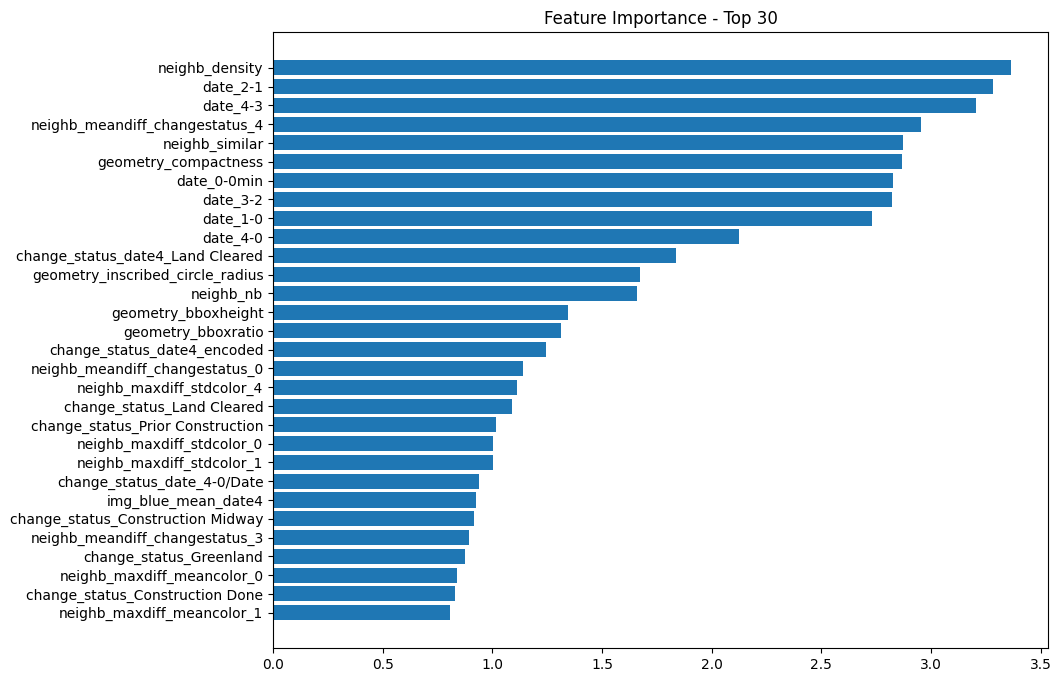

In [26]:

TOP = 30

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], np.array(feature_names)[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()


In [27]:
## Save results to submission file
pred_df = pd.DataFrame(pred, columns=['change_type'])
pred_df.to_csv("data/CATBOOST.csv", index=True, index_label='Id')

In [28]:
np.save("data/PROBS_CATBOOST", pred_probs)